# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IoT)

### Entrada (input)

1. Problema de negócio:
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados:
    - Vendas de um e-commerce online, durante o período de 1 ano (11/2015 a 12/2017)
    

### Saída (output)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
           10323     | yes/1 
           32413     | no/1
             
2. Relatório om as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo ?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento ?

### Tarefas (tasks)

- Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível ? O que são clientes de maior "valor" ?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixo recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
        
    - Experiência de Compra:
        - Média Alta de avaliações
        
        
- Quantos clientes farão parte do grupo ?
    - Número total de clientes
    - % clientes Insiders
    
- Quais as principais características desses clientes ?
    - Escrever características do cliente:
        - Idade
        - Localização
        
    - Escrever características de consumo:
        - Atributos da clusterização
        
        
- Qual a porcentagem de contribuição do faturamento, vinda dos Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort
    
- Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser similar ou parecida com outra pessoa do grupo
    
- Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir periodicidade (1 mês, 3 meses ...)
    - A pessoa precisa ser dessimilar ou não parecida com outra pessoa do grupo
    
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste de hipóteses
    - Teste A/B Bayesiano

- Quais ações o time de marketing pode realizar para aumentar o faturamento ?
     - Desconto
     - Preferencia de compra
     - Frete
     - Visita a empresa

# 0.0 Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from umap.umap_ import UMAP

from plotly import express as px


from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


from ydata_profiling import ProfileReport

# 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,9]
    plt.rcParams['font.size'] = 15
    
#     display(HTML('<style>.container { width:100% important;}</style>'))
    pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Load Data

In [3]:
caminho = r'C:\repos\portfolio_projetos\pa005_insider_clustering\data'
df_raw = pd.read_csv(caminho + '\Ecommerce.csv', encoding = 'iso 8859-1')
df_raw = df_raw.drop(['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


# 1.0 Descrição os dados

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [5]:
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


## 1.2 Data dimension

In [6]:
print("Number of rows: {} \nNumber of columns: {}".format(df1.shape[0], df1.shape[1]))

Number of rows: 541909 
Number of columns: 8


## 1.3 Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna() ]
df_not_missing = df1.loc[~df1['customer_id'].isna() ]
df_not_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


In [10]:
print('Missing => {}  and NOT missing => {}'.format(df_missing.shape[0],df_not_missing.shape[0]))

Missing => 135080  and NOT missing => 406829


In [11]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:9]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553']

In [12]:
df_not_missing.loc[df_not_missing['invoice_no'].isin( missing_invoice )]
# nao existe invoice_no do missing presente no not missing

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [13]:
# atribuição dos novos "customer_id", apenas para nao perder os dados dos 25%
#df_not_missing['customer_id'].max()  # 18287

In [14]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )
df1 = df1.drop(['customer_id_y','customer_id_x'], axis = 1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,United Kingdom,17850.0000
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,United Kingdom,17850.0000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,United Kingdom,17850.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,United Kingdom,17850.0000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,United Kingdom,17850.0000


In [15]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [16]:
# com a mudança dos missings acima, rodar novamente as analises descritivas abaixo para verificar mudanças de comportamento

In [17]:
# # remove
# df1 = df1.dropna(subset = ['description','customer_id'])

# print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

In [18]:
# df1.isna().sum()

## 1.6 Change dtypes

In [19]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.5500,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.3900,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.7500,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.3900,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.3900,United Kingdom,17850


In [20]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [21]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [22]:
# central tendency - mean / median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std / skew / kurtosis / min / max
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0000,80995.0000,161990.0000,9.5522,3.0000,218.0810,-0.2641,119769.1600
1,unit_price,-11062.0600,38970.0000,50032.0600,4.6111,2.0800,96.7598,186.5070,59005.7191
2,customer_id,12346.0000,22709.0000,10363.0000,16688.8405,16249.0000,2911.4087,0.4874,-0.8043


In [23]:
# quantidade com valor negativo ? (Devolução)
# preço unitario de zero ? Promoção ?


### 1.7.2 Categorical Attributes

In [24]:
# cat_attributes['invoice_no'].astype('int64')
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x)) )]
print('Total of invoices with letter: ', df_letter_invoices.shape[0])
print('Total of invoices with letter and quantity < 0: ',df_letter_invoices.loc[
                                        df_letter_invoices['quantity'] < 0].shape[0])

Total of invoices with letter:  9291
Total of invoices with letter and quantity < 0:  9288


In [25]:
# stock code
# pegar somente letras
df1.loc[df1['stock_code'].apply( lambda x: bool(re.search('^[a-zA-Z]+$', x)) ),
                   'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [26]:
# acao:  remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


In [27]:
# description
df1.head()

# delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.5500,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.3900,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.7500,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.3900,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.3900,United Kingdom,17850


In [28]:
# country
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [29]:
df1['country'].value_counts( normalize = True).head()

United Kingdom   0.9143
Germany          0.0175
France           0.0158
EIRE             0.0151
Spain            0.0047
Name: country, dtype: float64

In [30]:
df1[['country','customer_id']].drop_duplicates().groupby('country').count().sort_values(by = 'customer_id',
                                                                                        ascending = False).head()

,customer_id
country,
United Kingdom,7587
Germany,95
France,90
EIRE,44
Spain,31


# 2.0 Filtragem das variáveis

In [31]:
df2 = df1.copy()

In [32]:
df2.sort_values(['customer_id','invoice_no','description']).head(10) 
# há devolução se olhar o primeiro individuo, pois o "C" parece ser a flag para devolução

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.0400,United Kingdom,12346
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.0400,United Kingdom,12346
14966,537626,84558A,3D DOG PICTURE PLAYING CARDS,24,2016-12-05,2.9500,Iceland,12347
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2016-12-05,4.2500,Iceland,12347
14948,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,2016-12-05,3.7500,Iceland,12347
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,2016-12-05,3.7500,Iceland,12347
14952,537626,22729,ALARM CLOCK BAKELIKE ORANGE,4,2016-12-05,3.7500,Iceland,12347
14951,537626,22728,ALARM CLOCK BAKELIKE PINK,4,2016-12-05,3.7500,Iceland,12347
14950,537626,22727,ALARM CLOCK BAKELIKE RED,4,2016-12-05,3.7500,Iceland,12347
14955,537626,21171,BATHROOM METAL SIGN,12,2016-12-05,1.4500,Iceland,12347


In [33]:
# quantity (negative)
df2.loc[df2['quantity'] < 0 ].sort_values('invoice_no').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
2406,536589,21777,NaN,-10,2016-11-29,0.0000,United Kingdom,19013
4347,536764,84952C,NaN,-38,2016-11-30,0.0000,United Kingdom,19019
7188,536996,22712,NaN,-20,2016-12-01,0.0000,United Kingdom,19036
7189,536997,22028,NaN,-20,2016-12-01,0.0000,United Kingdom,19037
7190,536998,85067,NaN,-6,2016-12-01,0.0000,United Kingdom,19038


In [34]:
#====== NUMERICAL ===========
# unity price > 0
df2 = df2.loc[df2['unit_price'] > 0.040]

# stock code != ['POST, D, M, DOT, CRUK]
df2 = df2.loc[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop(['description'], axis = 1)

# country change
df2 = df2.loc[ ~df2['country'].isin( ['Unspecified','European Community'])]


# esse cliente apareceu com compras e estornos altos após o pandas profiling na etapa de verificar outliers
df2 = df2.loc[~df2['customer_id'].isin( [16446])]


# quantity
df2_returns = df2.loc[ df2['quantity'] < 0]
df2_purchases = df2.loc[ df2['quantity'] >= 0]

# 3.0 Feature Engineering

In [35]:
df3 = df2.copy()

## 3.1 Feature creation

In [36]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis = 1).drop_duplicates().reset_index(drop = True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross revenue

In [37]:
# gross revenue = quantity * price (faturamento)
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

In [38]:
# monetary
df_monetary = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

In [39]:
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id',how = 'left')

df_ref.isna().sum() # tem NA por conta de ser somente as compras 'positivas'

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - day from last purchase

In [40]:
# recency - last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

# pego o df1 com max() pois eu considero que seria eu olhando pra "hoje" no meu dataset e tirando 'hoje - datas'
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date']  ).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchased

In [41]:
# number of products
df_frequency = df2_purchases[['customer_id','invoice_no']].drop_duplicates().groupby(
                                'customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'})
df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Quantity total of items purchased

In [42]:
# number of products
df_frequency = df2_purchases[['customer_id','quantity']].groupby(
                                            'customer_id').sum().reset_index().rename(columns={'quantity':'qtde_items'})
df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5 Quantity of unique products purchased

In [43]:
# number of products
df_frequency = df2_purchases[['customer_id','stock_code']].groupby(
                                'customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

In [44]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000
1,13047,3232.5900,56.0000,9.0000,1390.0000,171.0000
2,12583,6705.3800,2.0000,15.0000,5028.0000,232.0000
3,13748,948.2500,95.0000,5.0000,439.0000,28.0000
4,15100,876.0000,333.0000,3.0000,80.0000,3.0000


### 3.1.5 Average ticket value

In [45]:
# average ticket
df_avg_ticket = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(
                                                            columns = {'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6 Average recency days

In [46]:
# recency days  average
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(
            by=['customer_id','invoice_date'],ascending = [False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['previous_date'] - x['invoice_date']).days 
                                          if x['customer_id'] == x['next_customer_id']
                                         else np.nan, axis = 1)

df_aux = df_aux.drop( ['invoice_date','next_customer_id','previous_date'], axis = 1).dropna()

# average
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency purchase

In [47]:
df2[['invoice_no','customer_id','invoice_date']].drop_duplicates().head()

,invoice_no,customer_id,invoice_date
0,536365,17850,2016-11-29
7,536366,17850,2016-11-29
9,536367,13047,2016-11-29
21,536368,13047,2016-11-29
25,536369,13047,2016-11-29


In [48]:
df_aux = df2_purchases[['invoice_no','customer_id','invoice_date']].drop_duplicates().groupby('customer_id').agg(
                    max_ = ('invoice_date','max'),
                    min_ = ('invoice_date','min'),
                    days_ = ('invoice_date',lambda x: (x.max() - x.min()).days + 1),
                    buy_ = ('invoice_date','count')).reset_index()

# frequency
df_aux['frequency'] = df_aux[['days_','buy_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0
                                                else 0, axis = 1)
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on = 'customer_id', how = 'left')
df_ref

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,35.5000,17.0000
1,13047,3232.5900,56.0000,9.0000,1390.0000,171.0000,18.9040,27.2500,0.0283
2,12583,6705.3800,2.0000,15.0000,5028.0000,232.0000,28.9025,23.1875,0.0403
3,13748,948.2500,95.0000,5.0000,439.0000,28.0000,33.8661,92.6667,0.0179
4,15100,876.0000,333.0000,3.0000,80.0000,3.0000,292.0000,8.6000,0.0732
...,...,...,...,...,...,...,...,...,...
5781,22706,5699.0000,1.0000,1.0000,1747.0000,634.0000,8.9890,NaN,1.0000
5782,22707,6756.0600,0.0000,1.0000,2010.0000,730.0000,9.2549,NaN,1.0000
5783,22708,3217.2000,0.0000,1.0000,654.0000,59.0000,54.5288,NaN,1.0000
5784,22709,3950.7200,0.0000,1.0000,731.0000,217.0000,18.2061,NaN,1.0000


In [49]:
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of returns

In [50]:
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_returns.rename(columns = {'quantity':'qtde_returns'}, inplace = True)

df_returns['qtde_returns'] = df_returns['qtde_returns'] * ( -1 )

df_ref = pd.merge(df_ref, df_returns, on = 'customer_id', how = 'left')

df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket size
Quantity of items in a basket
- Inovice No = compra = purchase
- Stock Code = produto = product
- Quantity = Item = item

In [51]:
df_aux = df2_purchases[['customer_id','invoice_no','quantity']].groupby('customer_id').agg(
                                                    n_purchase = ('invoice_no','nunique'),
                                                    n_products = ('quantity','sum')).reset_index()

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique basket size

In [52]:
df_aux = df2_purchases[['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(
                                                    n_purchase = ('invoice_no','nunique'),
                                                    n_products = ('stock_code','nunique')).reset_index()

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_unique_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA (exploratory data analysis)

In [53]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate analysis

**Notes**
1. Clusters coesos => separados
2. Métricas
    - Mínimo, Máximo, Range (dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação (CV = DesvPad / Média)
    - Distribuição

**Notes**


In [54]:
# profile = ProfileReport( df4 )
# profile.to_file('output_v3.html')

### 4.1.1 Gross revenue

In [55]:
df4.loc[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.0200,1.0000,72.0000,196844.0000,2060.0000,135.5039,7.8444,0.2034,288.0000,2733.9444,9.7083


### 4.1.2 Qtde items

In [56]:
df3[df3['customer_id'] == 14646].head(25)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.2900,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.2900,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.9500,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.9500,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.8500,Netherlands,14646
37957,539491,20751,1,2016-12-18,2.1000,Netherlands,14646
37958,539491,21246,2,2016-12-18,4.9500,Netherlands,14646
37959,539491,22960,1,2016-12-18,4.2500,Netherlands,14646
37960,539491,22355,2,2016-12-18,0.8500,Netherlands,14646
37961,539491,21123,2,2016-12-18,1.2500,Netherlands,14646


### 4.1.3 qtde products

In [57]:
df4[df4['qtde_products'] > 7000]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.7200,1.0000,124.0000,22853.0000,7837.0000,5.2265,3.3214,0.3324,203.0000,184.2984,10.6532


In [58]:
df3[df3['customer_id'] == 17841].sort_values(by=['unit_price','quantity'], ascending = [False, False]).head(25)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
84390,543389,84078A,2,2017-02-06,39.9500,United Kingdom,17841
221430,556245,21686,2,2017-06-07,39.9500,United Kingdom,17841
260357,559807,84816,2,2017-07-10,39.9500,United Kingdom,17841
58553,541253,84078A,1,2017-01-14,39.9500,United Kingdom,17841
63625,541587,84078A,1,2017-01-17,39.9500,United Kingdom,17841
112089,545868,84078A,1,2017-03-05,39.9500,United Kingdom,17841
127200,547202,84078A,1,2017-03-19,39.9500,United Kingdom,17841
152731,549690,21686,1,2017-04-09,39.9500,United Kingdom,17841
213999,555562,84078A,1,2017-06-03,39.9500,United Kingdom,17841
235348,557636,21686,1,2017-06-19,39.9500,United Kingdom,17841


### 4.1.4 avg ticket

In [59]:
df4[df4['avg_ticket'] > 50000]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [60]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.5 frequency

In [61]:
df4[df4['frequency'] > 10]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,35.5000,17.0000,40.0000,50.9706,0.6176


In [62]:
df3[df3['customer_id'] == 17850].sort_values(['quantity'], ascending = False).head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.7500,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.3900,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.5500,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.9500,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.3900,United Kingdom,17850
3809,536685,71053,12,2016-11-30,3.3900,United Kingdom,17850
4531,536790,37370,12,2016-11-30,1.0600,United Kingdom,17850
4532,536790,21071,12,2016-11-30,1.0600,United Kingdom,17850
4533,536790,21068,12,2016-11-30,1.0600,United Kingdom,17850
290,536396,82494L,12,2016-11-29,2.5500,United Kingdom,17850


### 4.1.6 avg basket size

In [63]:
df4[df4['avg_basket_size'] > 4000]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.3000,235.0000,3.0000,18028.0000,10.0000,4453.4300,97.0000,0.0306,9014.0000,6009.3333,1.6667
3278,12590,9341.2600,211.0000,1.0000,4282.0000,67.0000,139.4218,21.0000,1.0000,4.0000,4282.0000,67.0000


In [64]:
df3[df3['customer_id'] == 15749].sort_values(['quantity'], ascending = False).head(25)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52711,540815,21108,3114,2017-01-09,2.1000,United Kingdom,15749
160546,550461,21108,3114,2017-04-16,2.1000,United Kingdom,15749
52710,540815,21175,2000,2017-01-09,1.8500,United Kingdom,15749
160545,550461,21175,2000,2017-04-16,1.6900,United Kingdom,15749
52709,540815,85123A,1930,2017-01-09,2.5500,United Kingdom,15749
160542,550461,85123A,1930,2017-04-16,2.4000,United Kingdom,15749
52771,540818,47556B,1300,2017-01-09,2.5500,United Kingdom,15749
160543,550461,47556B,1300,2017-04-16,2.1000,United Kingdom,15749
52772,540818,48185,670,2017-01-09,6.7500,United Kingdom,15749
160544,550461,48185,670,2017-04-16,6.3500,United Kingdom,15749


## 4.2 Bivariate analysis

In [65]:
cols = ['customer_id']
df42 = df4.drop(cols, axis = 1)

In [66]:
# plt.figure(figsize = (25,12) )
# sns.pairplot(df42)

**Notes**

1. frequency has low variance
2. avg_ticket has low variance

## 4.3 Space Study

In [67]:
df43 = df4.drop(['customer_id'], axis = 1).copy()
df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,35.5000,17.0000,40.0000,50.9706,0.6176
1,3232.5900,56.0000,9.0000,1390.0000,171.0000,18.9040,27.2500,0.0283,35.0000,154.4444,11.6667
2,6705.3800,2.0000,15.0000,5028.0000,232.0000,28.9025,23.1875,0.0403,50.0000,335.2000,7.6000
3,948.2500,95.0000,5.0000,439.0000,28.0000,33.8661,92.6667,0.0179,0.0000,87.8000,4.8000
4,876.0000,333.0000,3.0000,80.0000,3.0000,292.0000,8.6000,0.0732,22.0000,26.6667,0.3333


In [68]:
mm = MinMaxScaler()

In [69]:
for i in df43.columns:
    df43[i] = mm.fit_transform(df43[[i]])
    

In [70]:
X = df43.copy()

df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.0193,0.9973,0.1610,0.0088,0.0378,0.0036,0.0945,1.0000,0.0044,0.0083,0.0016
1,0.0116,0.1501,0.0390,0.0071,0.0217,0.0038,0.0719,0.0013,0.0039,0.0255,0.0443
2,0.0240,0.0054,0.0683,0.0255,0.0295,0.0060,0.0608,0.0021,0.0055,0.0556,0.0286
3,0.0034,0.2547,0.0195,0.0022,0.0034,0.0071,0.2511,0.0007,0.0000,0.0144,0.0178
4,0.0031,0.8928,0.0098,0.0004,0.0003,0.0651,0.0208,0.0040,0.0024,0.0043,0.0005


### 4.3.1 PCA

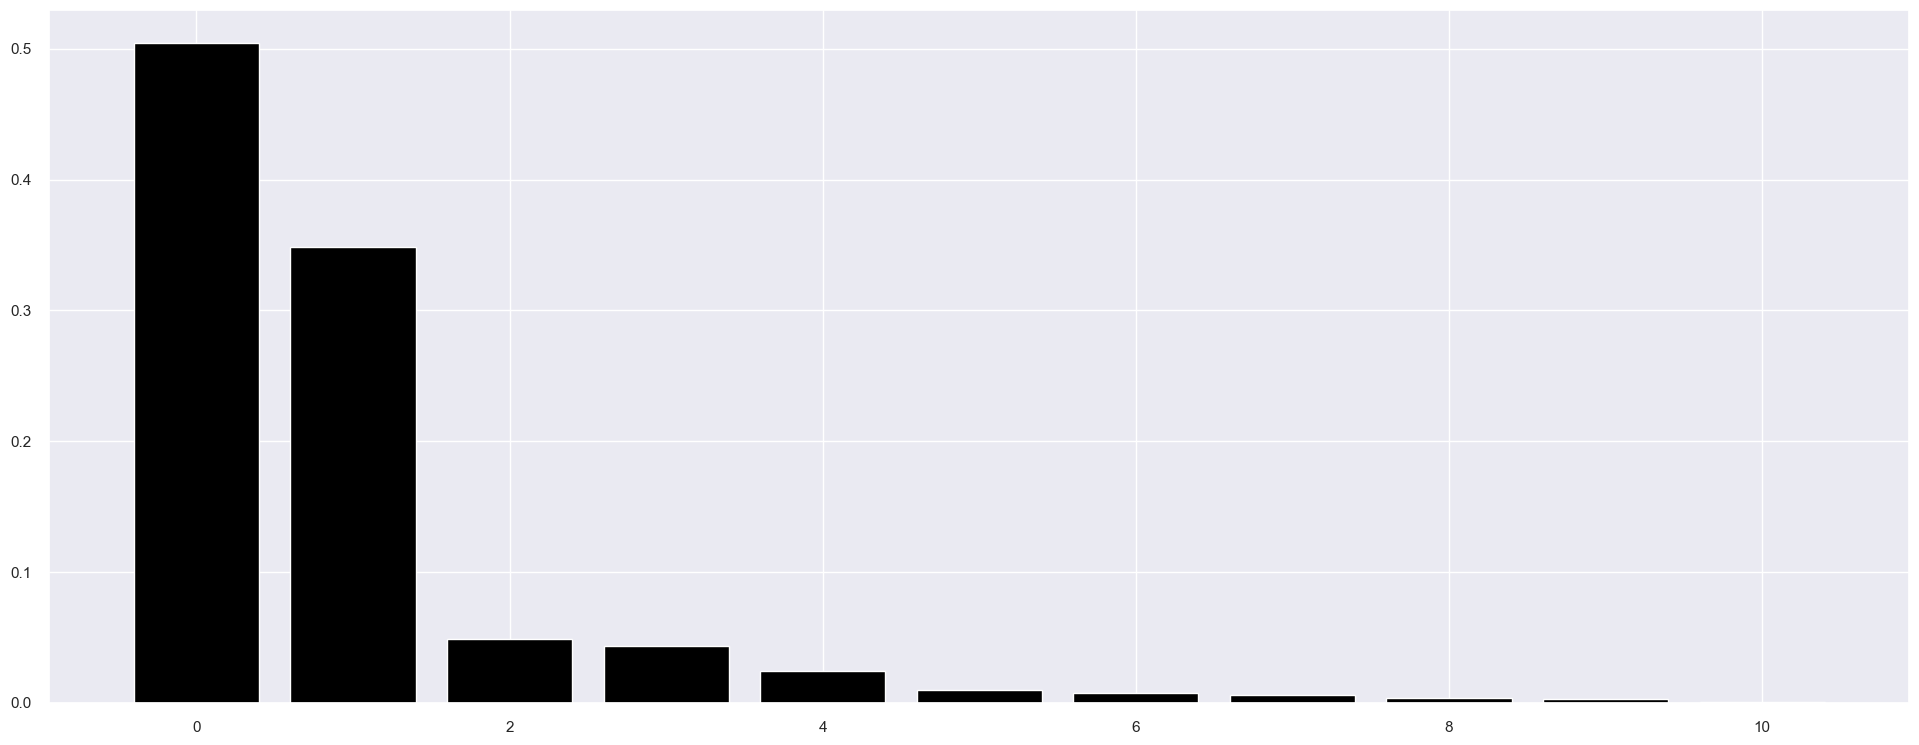

In [71]:
pca = PCA( n_components = X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explainable variables
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame( principal_components )

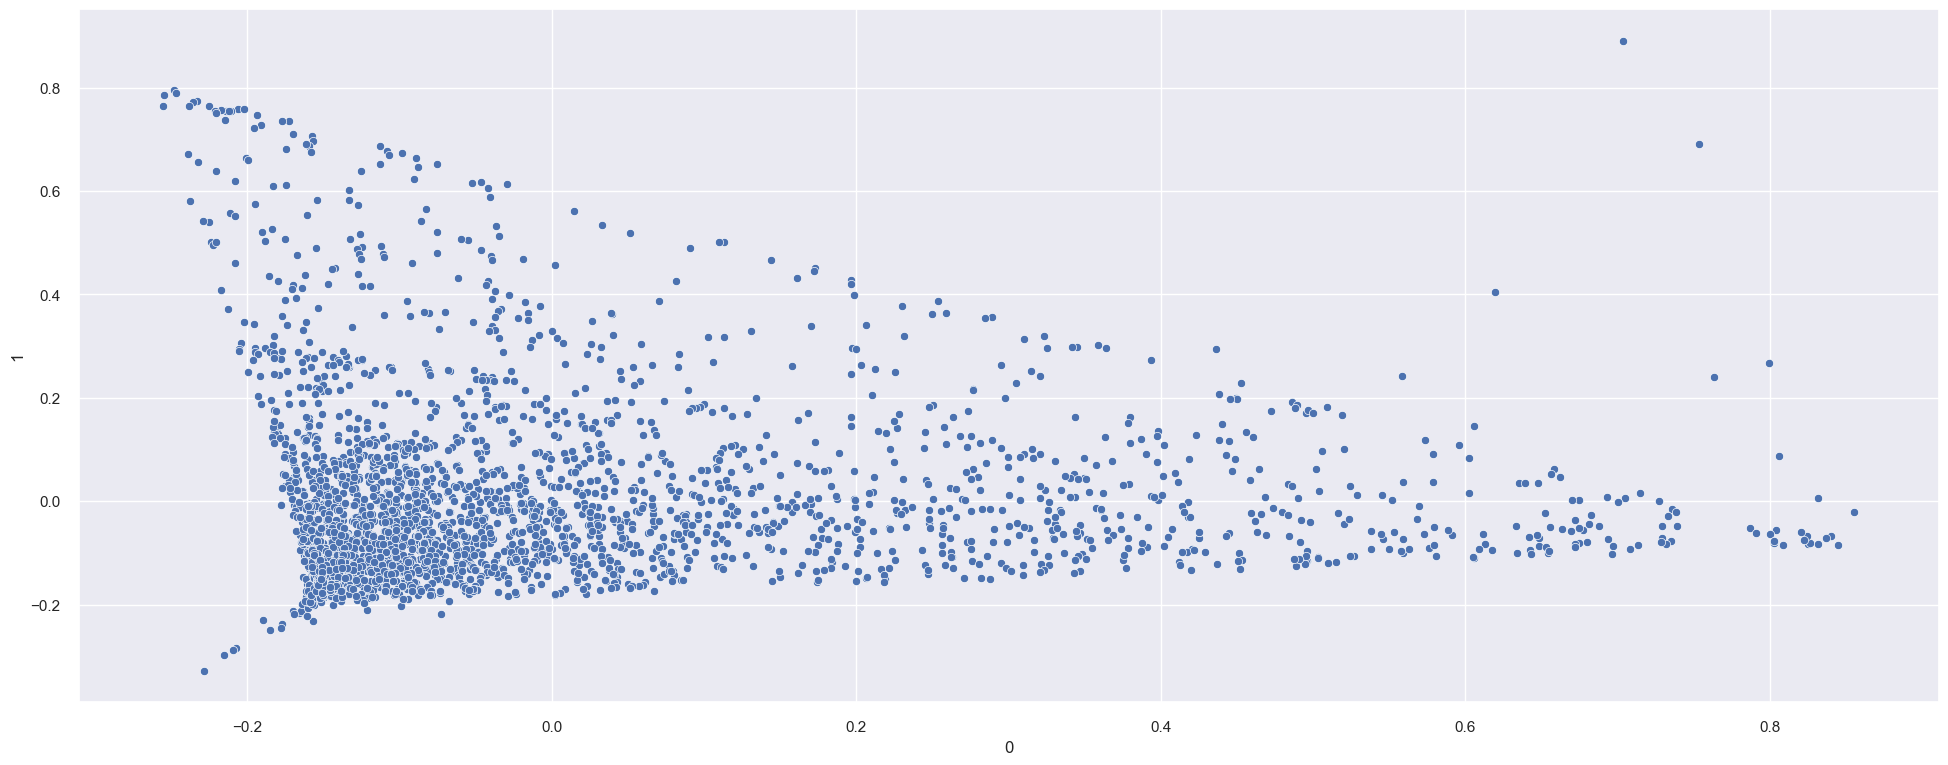

In [72]:
sns.scatterplot( x=0, y = 1, data = df_pca );

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

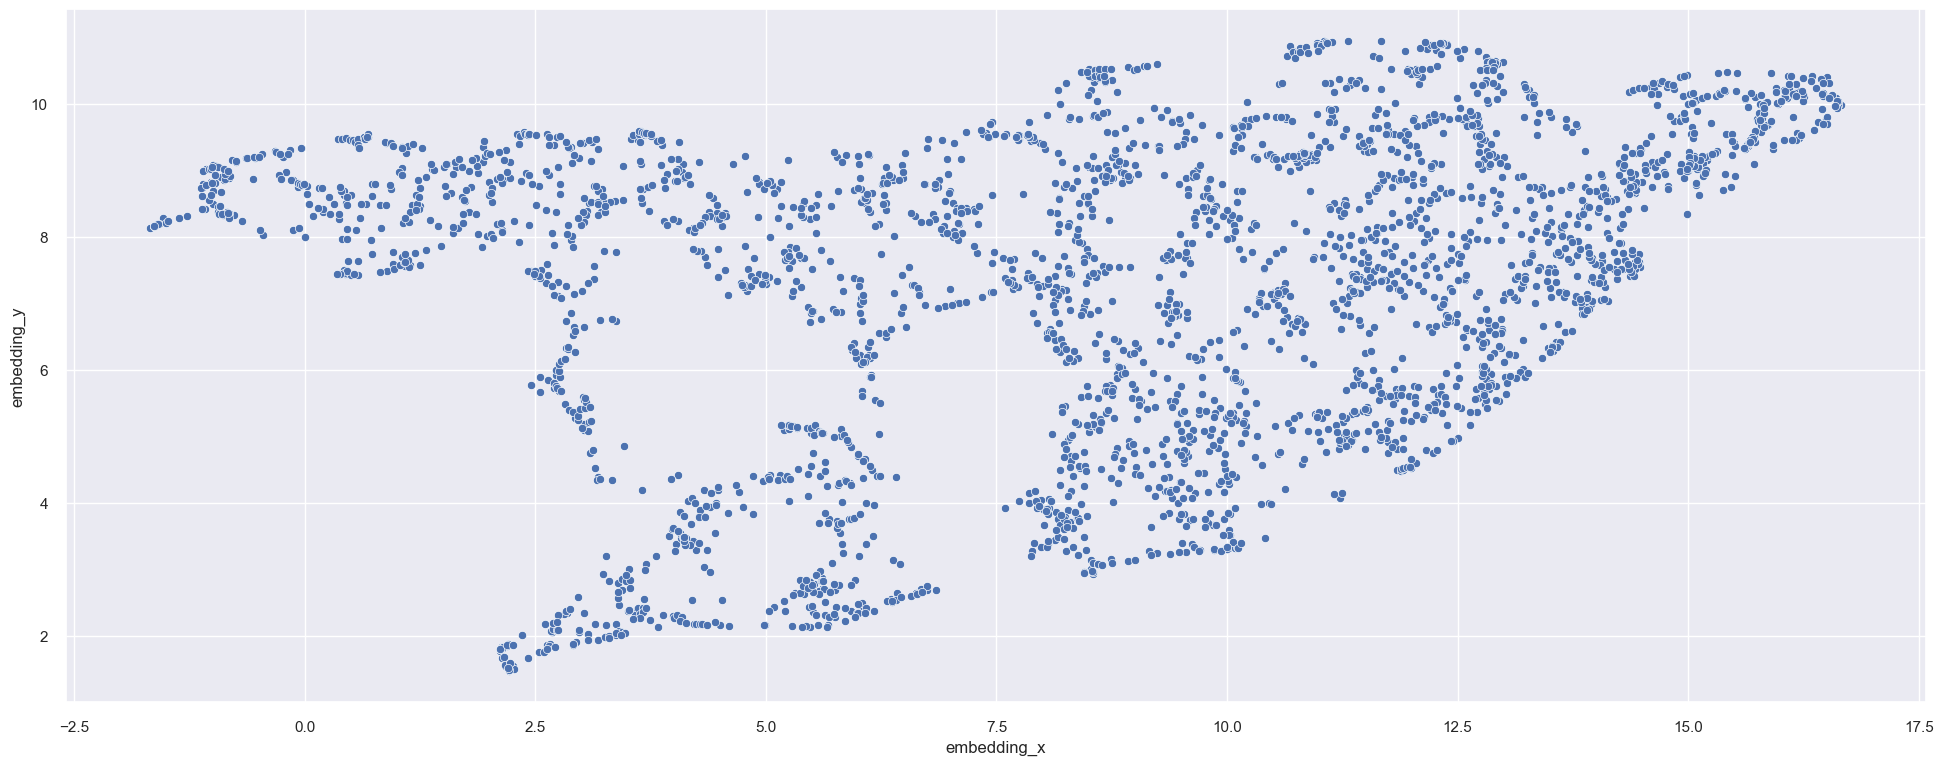

In [73]:
reducer = UMAP( random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_pca)

### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

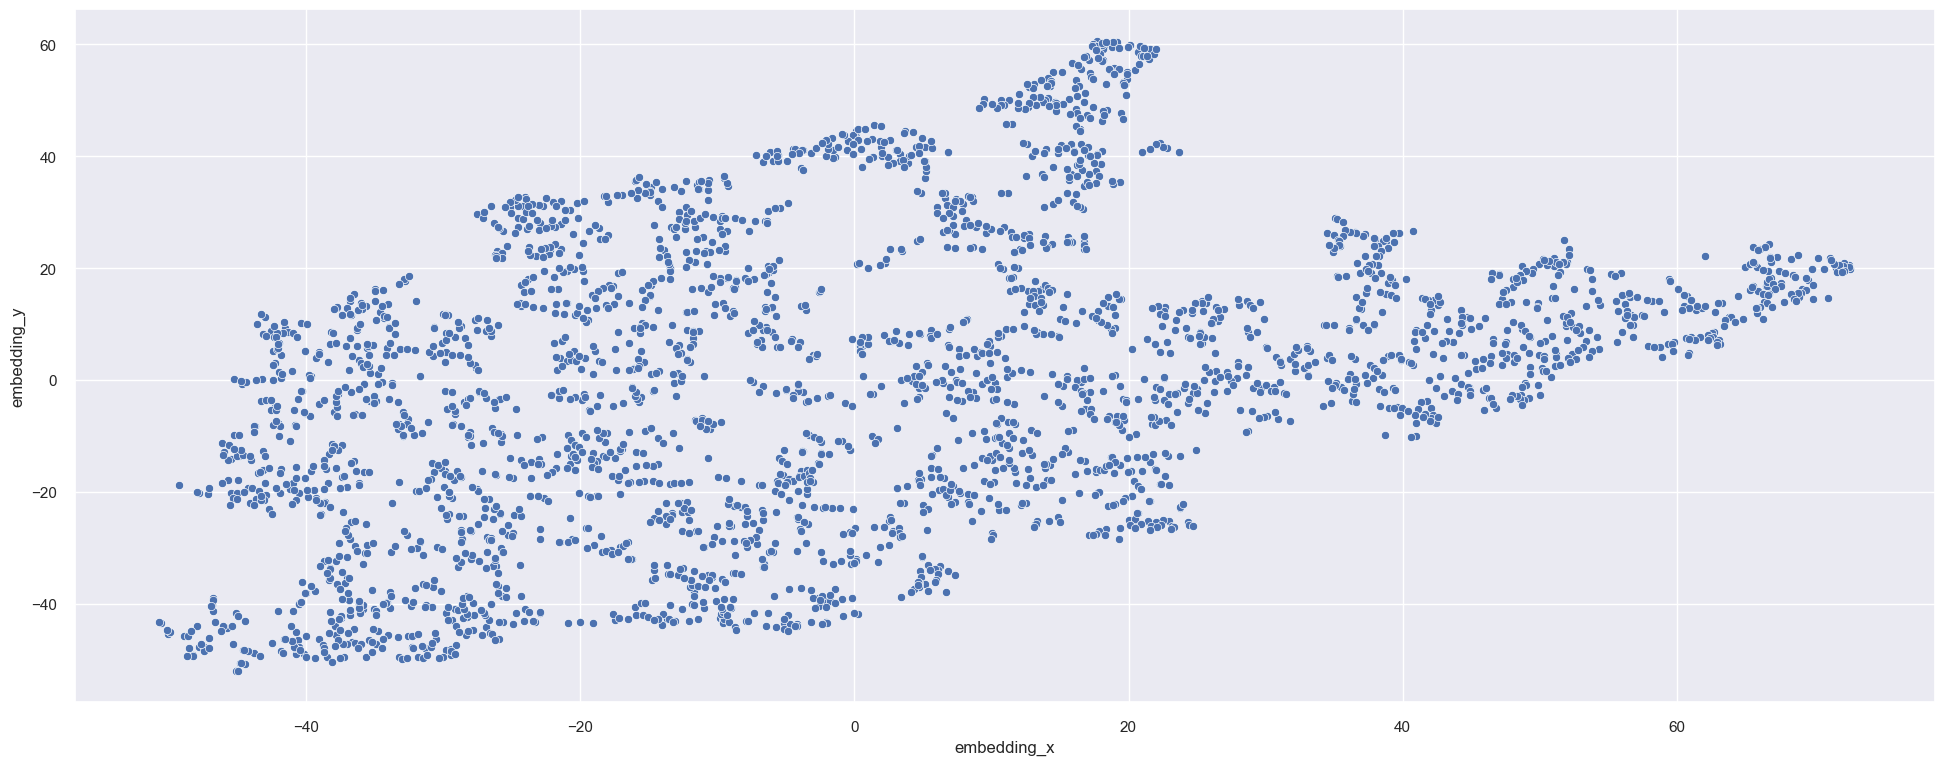

In [74]:
reducer = TSNE( n_components = 2, random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_pca)

### 4.3.4 Tree-Based Embedding

In [75]:
# training dataset
X = df4.drop(['customer_id','gross_revenue'], axis = 1)
Y = df4['gross_revenue']

# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state = 42)

# model training
rf_model.fit(X, Y)

# leaf


# dataframe leaf



RandomForestRegressor(random_state=42)

In [76]:
df_leaf = pd.DataFrame( rf_model.apply(X) )
df_leaf.shape

(2968, 100)

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

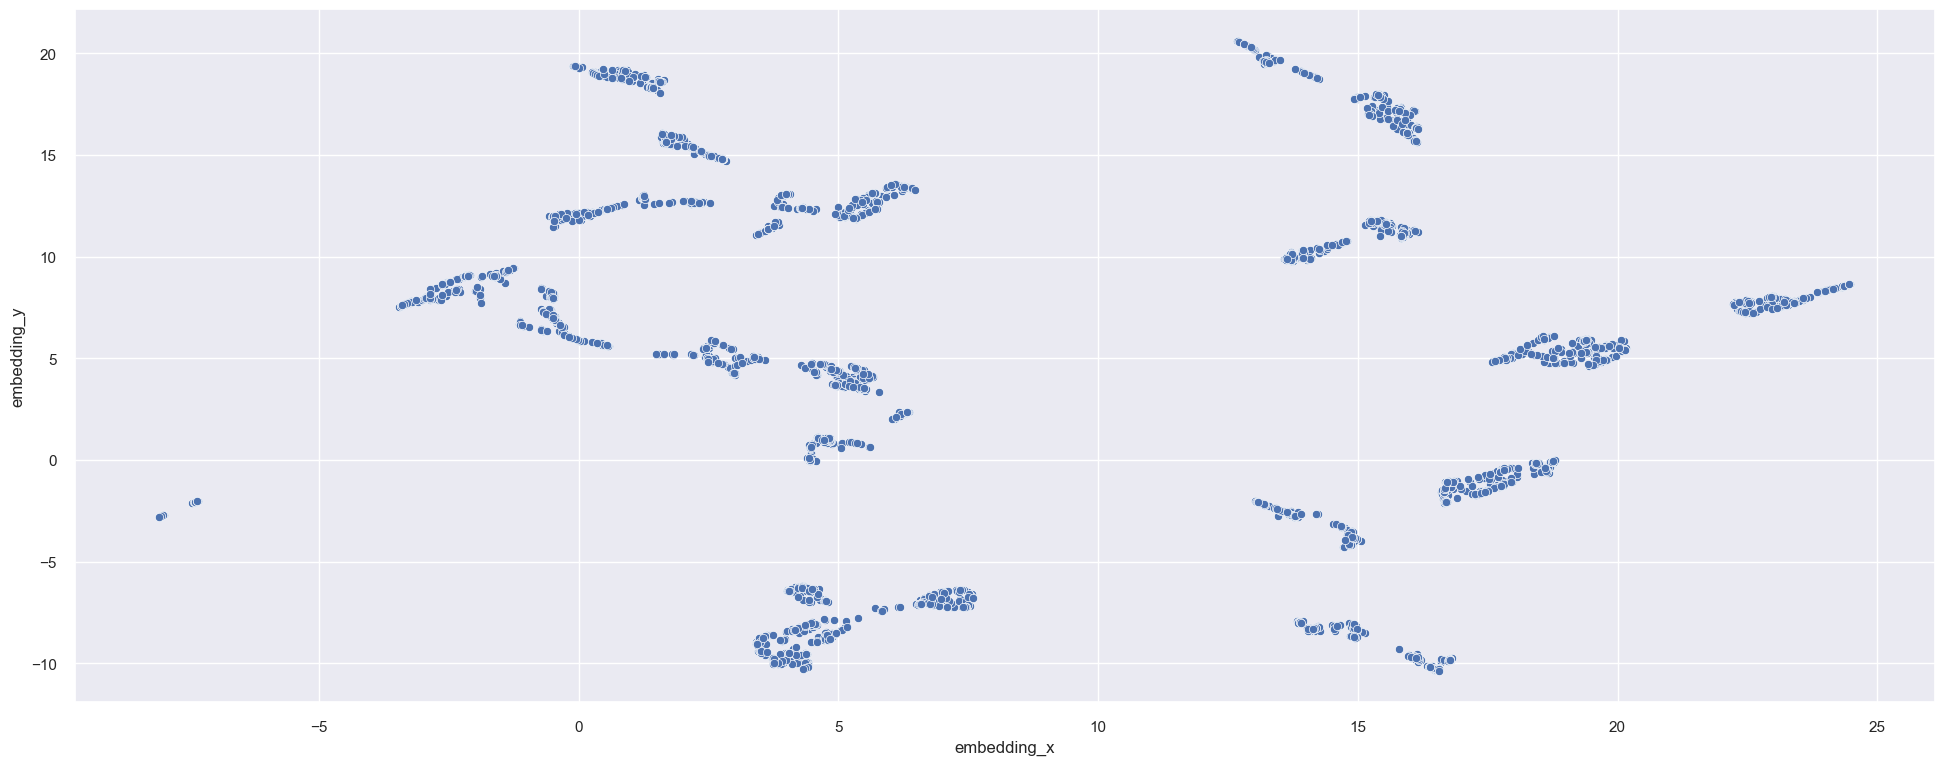

In [77]:
reducer = UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_pca)

# 5.0 Data Preparation

In [78]:
df5 = df4.copy()
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_items', 'qtde_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [79]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,35.5000,17.0000,40.0000,50.9706,0.6176
1,13047,3232.5900,56.0000,9.0000,1390.0000,171.0000,18.9040,27.2500,0.0283,35.0000,154.4444,11.6667
2,12583,6705.3800,2.0000,15.0000,5028.0000,232.0000,28.9025,23.1875,0.0403,50.0000,335.2000,7.6000
3,13748,948.2500,95.0000,5.0000,439.0000,28.0000,33.8661,92.6667,0.0179,0.0000,87.8000,4.8000
4,15100,876.0000,333.0000,3.0000,80.0000,3.0000,292.0000,8.6000,0.0732,22.0000,26.6667,0.3333


In [80]:
ss = MinMaxScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['qtde_invoices'] = ss.fit_transform( df5[['qtde_invoices']] )
df5['qtde_items'] = ss.fit_transform( df5[['qtde_items']] )
df5['qtde_products'] = ss.fit_transform( df5[['qtde_products']] )

df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['avg_recency_days'] = ss.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = ss.fit_transform( df5[['frequency']] )

df5['qtde_returns'] = ss.fit_transform( df5[['qtde_returns']] )
df5['avg_basket_size'] = ss.fit_transform( df5[['avg_basket_size']] )
df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']] )

In [81]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.0193,0.9973,0.1610,0.0088,0.0378,0.0036,0.0945,1.0000,0.0044,0.0083,0.0016
1,13047,0.0116,0.1501,0.0390,0.0071,0.0217,0.0038,0.0719,0.0013,0.0039,0.0255,0.0443
2,12583,0.0240,0.0054,0.0683,0.0255,0.0295,0.0060,0.0608,0.0021,0.0055,0.0556,0.0286
3,13748,0.0034,0.2547,0.0195,0.0022,0.0034,0.0071,0.2511,0.0007,0.0000,0.0144,0.0178
4,15100,0.0031,0.8928,0.0098,0.0004,0.0003,0.0651,0.0208,0.0040,0.0024,0.0043,0.0005


# 6.0 Feature Selection

In [82]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine Tunning

In [83]:
df6.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.0193,0.9973,0.1610,0.0088,0.0378,0.0036,0.0945,1.0000,0.0044,0.0083,0.0016
1,13047,0.0116,0.1501,0.0390,0.0071,0.0217,0.0038,0.0719,0.0013,0.0039,0.0255,0.0443
2,12583,0.0240,0.0054,0.0683,0.0255,0.0295,0.0060,0.0608,0.0021,0.0055,0.0556,0.0286
3,13748,0.0034,0.2547,0.0195,0.0022,0.0034,0.0071,0.2511,0.0007,0.0000,0.0144,0.0178
4,15100,0.0031,0.8928,0.0098,0.0004,0.0003,0.0651,0.0208,0.0040,0.0024,0.0043,0.0005


In [91]:
X = df6.drop(['customer_id'], axis = 1)
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.0193,0.9973,0.1610,0.0088,0.0378,0.0036,0.0945,1.0000,0.0044,0.0083,0.0016
1,0.0116,0.1501,0.0390,0.0071,0.0217,0.0038,0.0719,0.0013,0.0039,0.0255,0.0443
2,0.0240,0.0054,0.0683,0.0255,0.0295,0.0060,0.0608,0.0021,0.0055,0.0556,0.0286
3,0.0034,0.2547,0.0195,0.0022,0.0034,0.0071,0.2511,0.0007,0.0000,0.0144,0.0178
4,0.0031,0.8928,0.0098,0.0004,0.0003,0.0651,0.0208,0.0040,0.0024,0.0043,0.0005


In [101]:
clusters = [2,3,4,5,6,7]

## 7.1 K-Means

In [102]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = KMeans(n_clusters = k)

    # model training
    kmeans_model.fit( X )


    # model prediction
    labels = kmeans_model.predict( X )

    # model evaluation
    sil = silhouette_score( X, labels, metric = 'euclidean')
    kmeans_list.append( sil )
    print(sil)

0.5079205376519834
0.5194460311898637
0.3649036188604241
0.3568855702391406
0.37218890931657306
0.3416899783508502


Text(0.5, 1.0, 'Silhouette Score  x  K clusters')

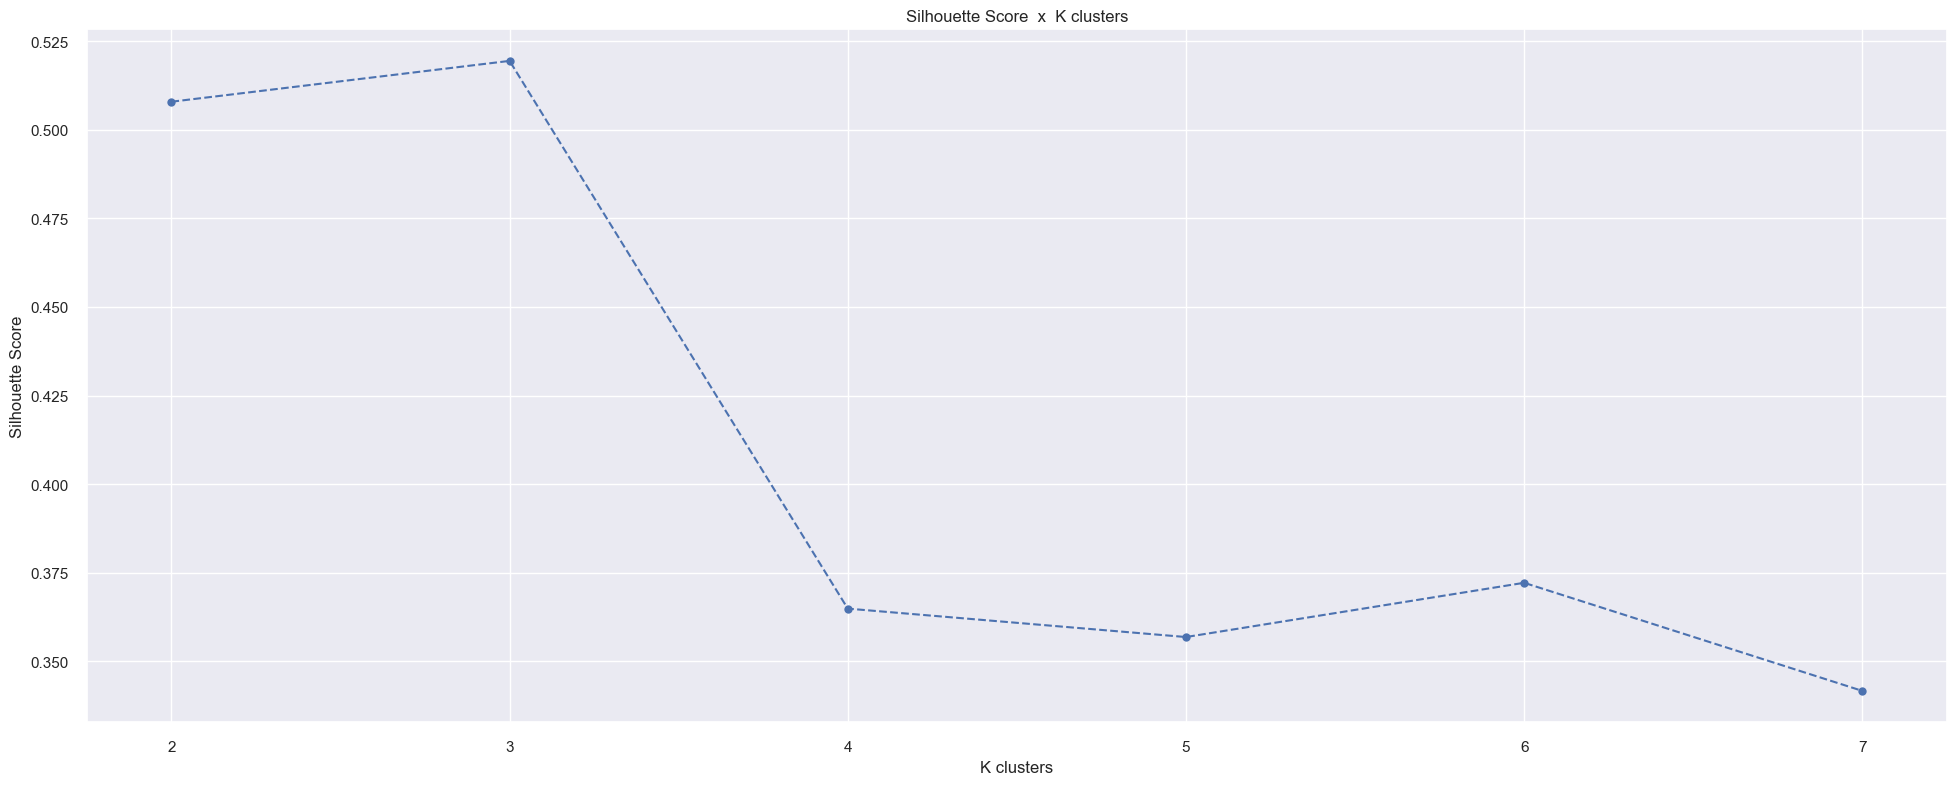

In [105]:
plt.plot( clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score  x  K clusters')

## 7.2 GMM

In [109]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = GaussianMixture(n_components = k)

    # model training
    gmm_model.fit( X )


    # model prediction
    labels = gmm_model.predict( X )

    # model evaluation
    sil = silhouette_score( X, labels, metric = 'euclidean')
    gmm_list.append( sil )
    print(sil)

0.1745276961239745
0.012893160242029869
-0.033512447312707055
-0.09075812886926897
-0.07836661450591681
-0.08465401089857401


Text(0.5, 1.0, 'Silhouette Score  x  GMM clusters')

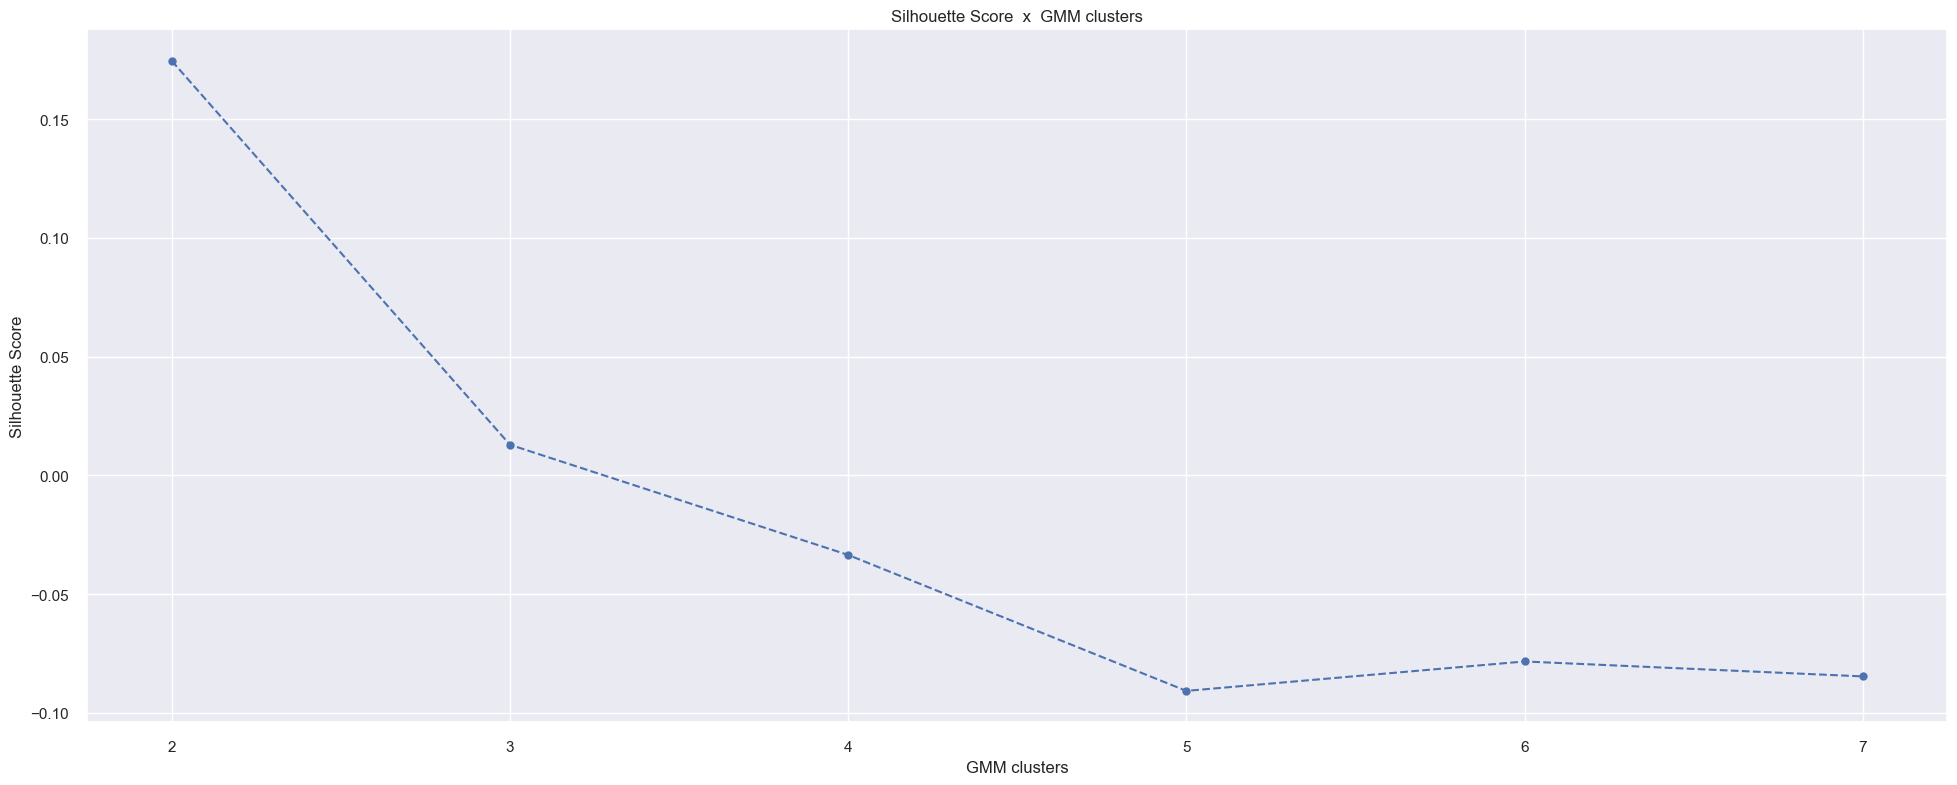

In [110]:
plt.plot( clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('GMM clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score  x  GMM clusters')

## 7.3 Hierarchical Clustering

## 7.4 DBSCAN

## 7.5 Results

In [115]:
df_results = pd.DataFrame(
{'KMeans': kmeans_list,
'GMM':gmm_list} ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7
KMeans,0.507921,0.519446,0.364904,0.356886,0.372189,0.341690
GMM,0.174528,0.012893,-0.033512,-0.090758,-0.078367,-0.084654


## 7.1 Within-Cluster Sum of Squares (WSS)

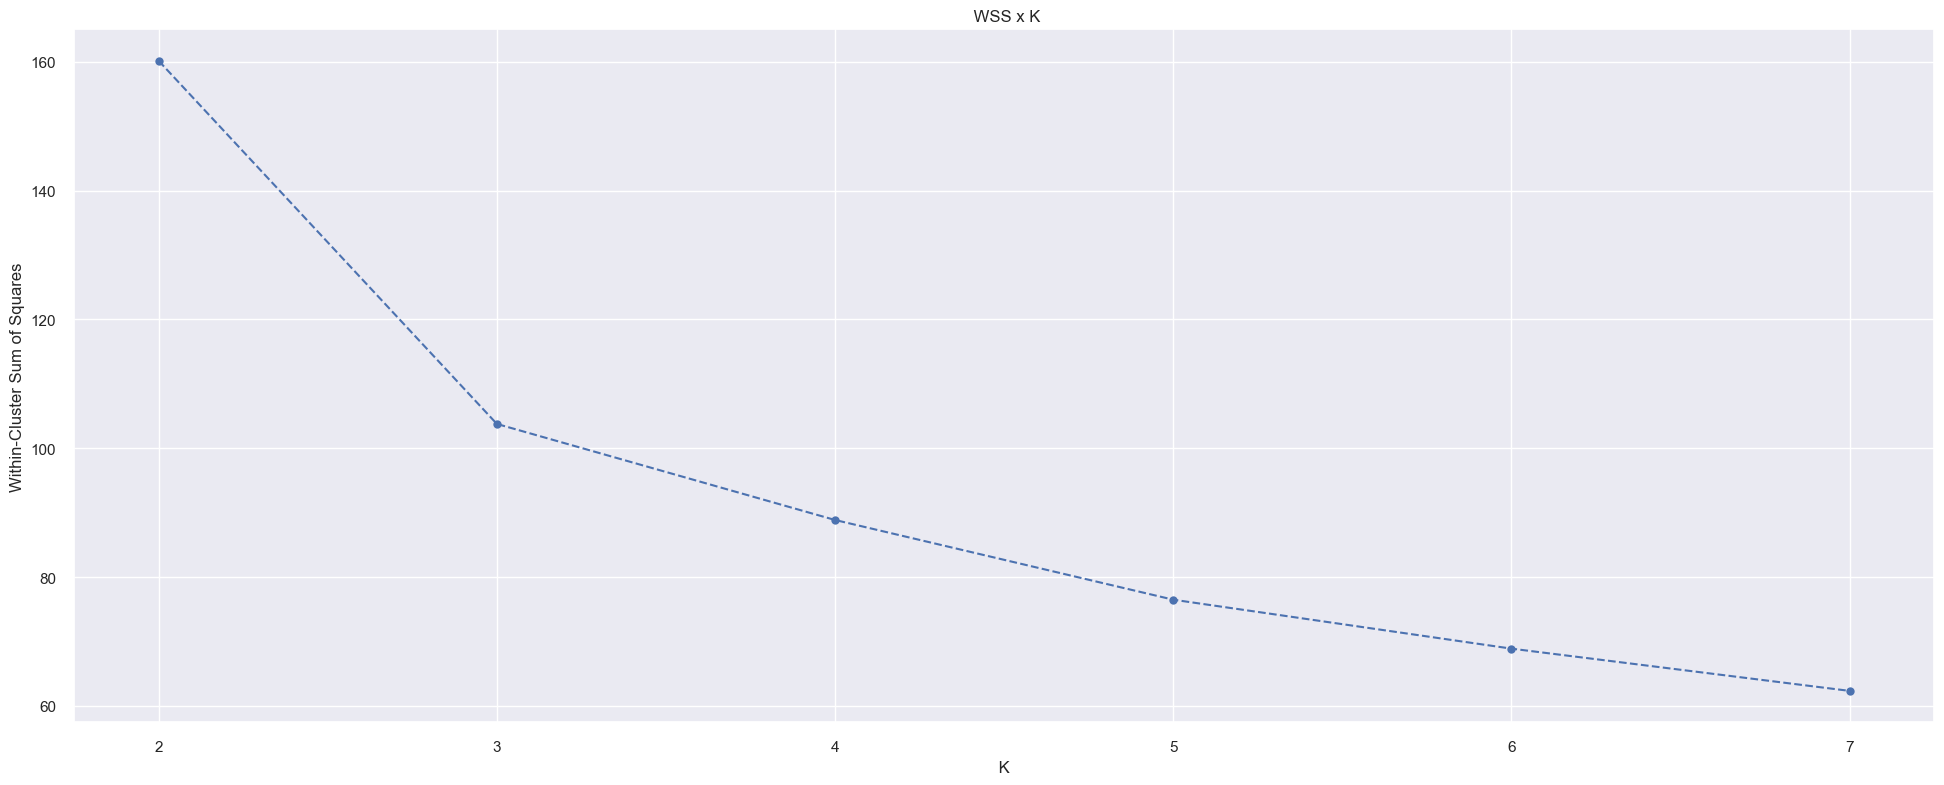

In [86]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters= k, n_init = 10, max_iter= 300, random_state= 42)

    # model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss - elbow method
plt.plot( clusters, wss, linestyle = '--', marker = 'o', color = 'b')
plt.xlabel(' K ')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title(' WSS x K');

## 7.2 Silhouette Score

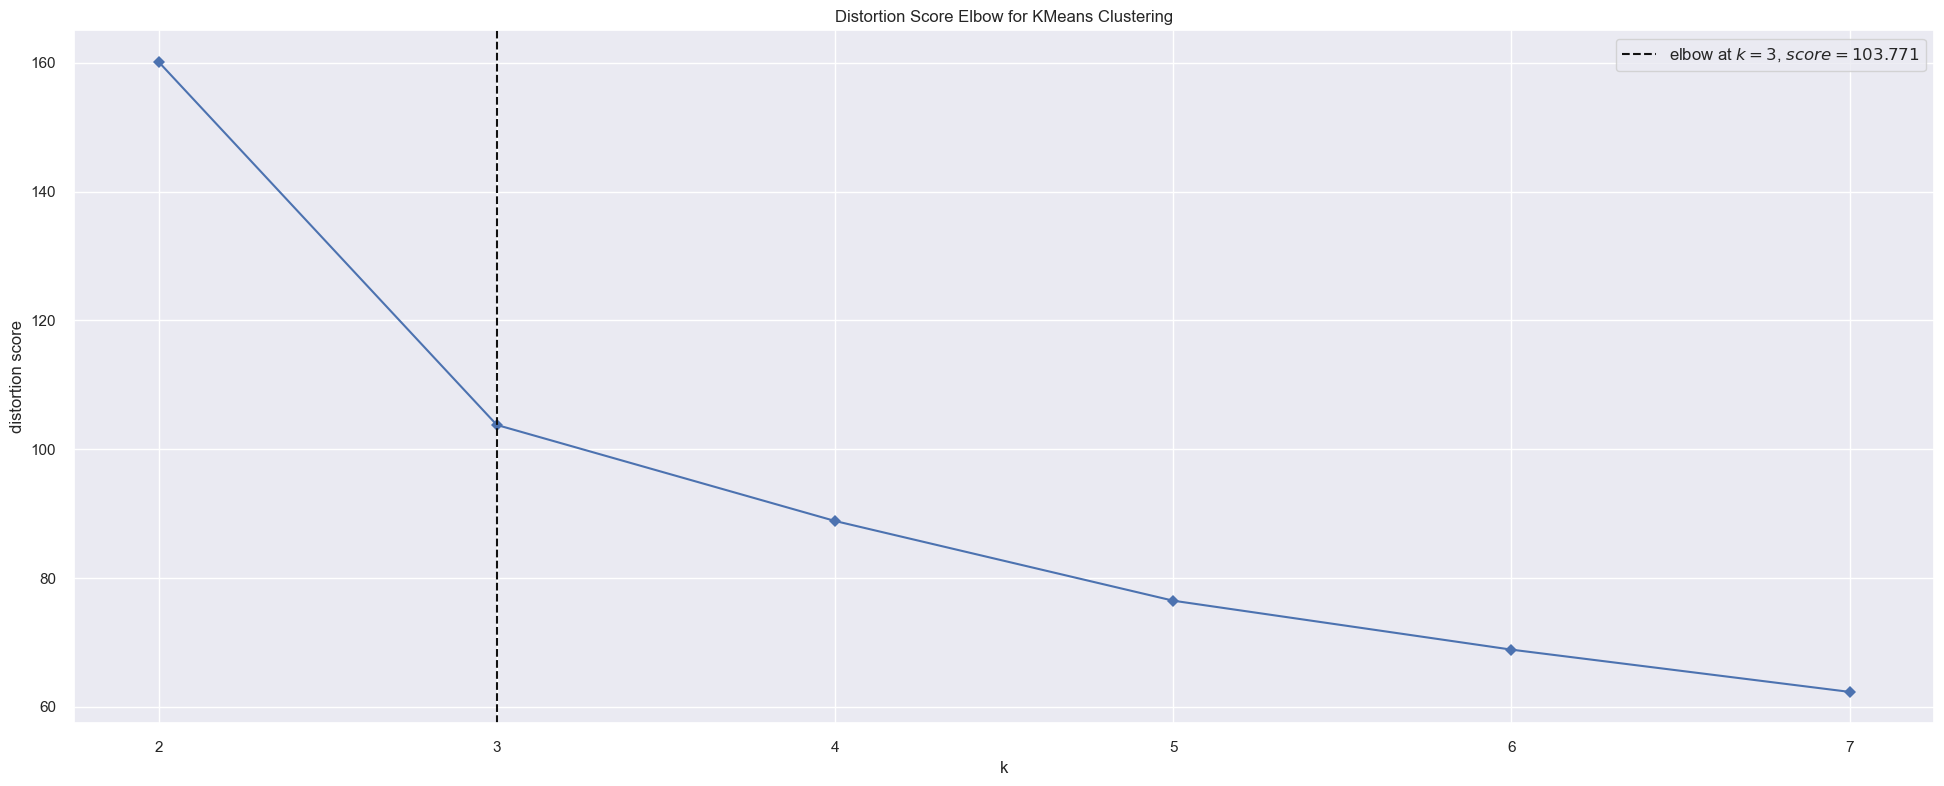

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [87]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, timings=False)
kmeans.fit(X)
kmeans.show()

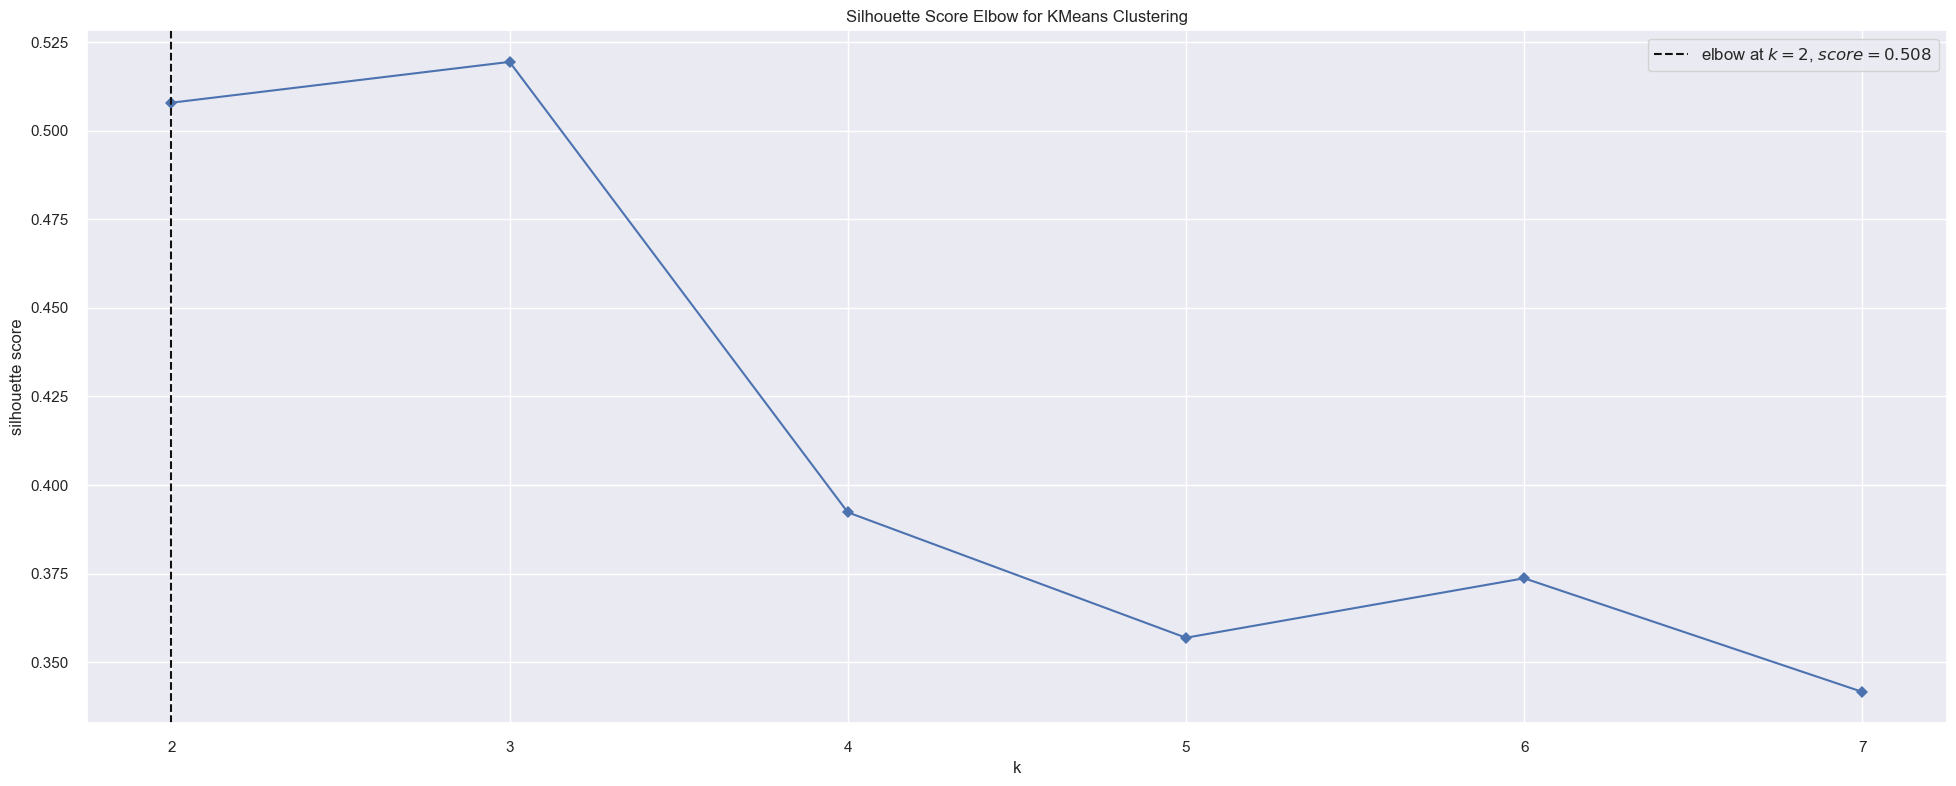

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [88]:
kmeans = KElbowVisualizer(KMeans(), k = clusters, metric= 'silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 7.3 Silhouette Analysis

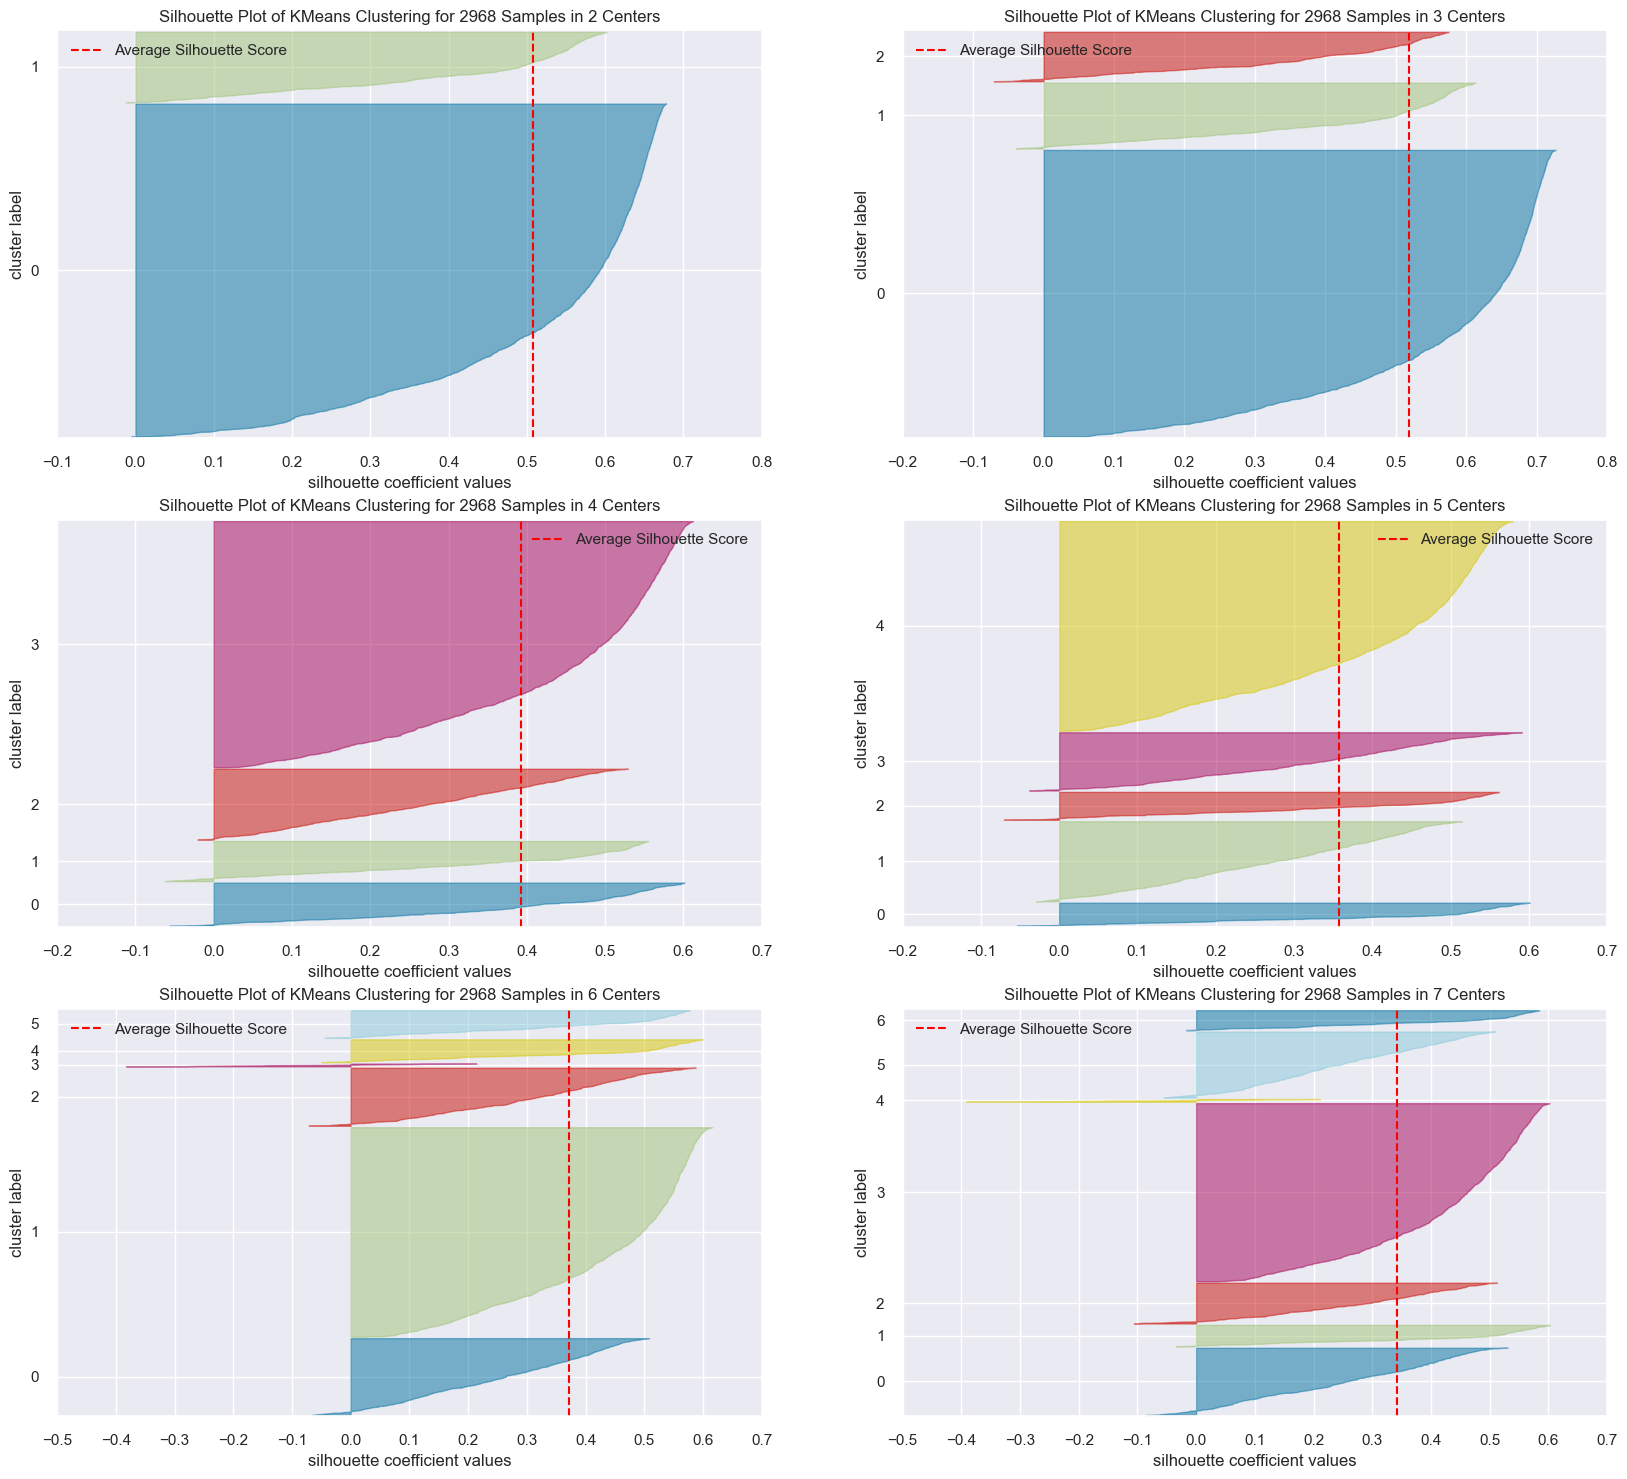

In [89]:
fig, axes = plt.subplots(3,2,figsize=(20,18))
for k in clusters:
    km = KMeans(n_clusters=k, init= 'random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k, 2)
    visualizer = SilhouetteVisualizer(km,colors = 'yellowbrick', ax = axes[q-1,mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [ ]:
# model definition
k = 3
kmeans = KMeans(init= 'random', n_clusters= k, n_init= 10, max_iter= 300, random_state= 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [ ]:
# WSS
print('WSS score: {}'.format(kmeans.inertia_))

## SS
print('SS score: {}'.format(silhouette_score(X, labels, metric = 'euclidean')))


# 9.0 Cluster Analysis

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1  Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer( kmeans, colors = 'yellowbrick')
visualizer.fit( X )
visualizer.finalize()

In [ ]:
df_viz = df9.drop(['customer_id'], axis = 1)

sns.pairplot( df_viz, hue = 'cluster')

## 9.2 UMAP

In [ ]:
reducer = UMAP(n_neighbors = 100,random_state= 42) 
# possui um hyperparametro chamado 'n_neighbors', que quanto menor, mais proximo do minimo local convergirá....quanto maior, mais se aproxima do minimo global

embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
                hue = 'cluster',palette = sns.color_palette('hls',n_colors = len(df_viz['cluster'].unique() ) ),
                data= df_viz
                )

## 9.2 Cluster Profile

In [ ]:
# number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# average gross revenue
df_cluster_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_gross_revenue, on = 'cluster', how = 'left')

# average recency days
df_cluster_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_recency_days, on = 'cluster', how = 'left')

# average invoice no
df_cluster_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'left')

# average ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on = 'cluster', how = 'inner')


df_cluster

- Cluster 01:
    - Número de clientes: 6 (0,14 % do total)
    - Recência média de 7 dias
    - Compras em média de 89 compras
    - Receita média de $ 182.181,98
    

- Cluster 02:
    - Número de clientes: 31 (0,71 % do total)
    - Recência média de 13 dias
    - Compras em média de 53 compras
    - Receita média de $ 40.543,52


- Cluster 03:
    - Número de clientes: 4335 (99,15 % do total)
    - Recência média de 92 dias
    - Compras em média de 4 compras
    - Receita média de $ 1372,58

# 10.0 Deploy to Production